
# **Procesamiento del Lenguaje Natural - NLP**

Se trabajará realizando un análisis de reviews en Yelp aplicando NLP.

Dado el siguiente enlace

https://drive.google.com/file/d/1sVeJE4zd1fmLnOgYI5QlQeaeaTGa8kIE/view?usp=sharing:

Instalamos librerías

In [106]:
!pip install transformers
!pip install sentence_transformers
!pip install keybert
!pip install bertopic

Descargamos el csv a nuestro entorno de trabajo

In [107]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1sVeJE4zd1fmLnOgYI5QlQeaeaTGa8kIE' -O reviews.csv

--2022-02-01 11:28:56--  https://docs.google.com/uc?export=download&id=1sVeJE4zd1fmLnOgYI5QlQeaeaTGa8kIE
Resolving docs.google.com (docs.google.com)... 74.125.195.139, 74.125.195.138, 74.125.195.113, ...
Connecting to docs.google.com (docs.google.com)|74.125.195.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-74-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/t30kavnjrvfj76peb4fs7r08183ee4s2/1643714925000/14260194928165318342/*/1sVeJE4zd1fmLnOgYI5QlQeaeaTGa8kIE?e=download [following]
--2022-02-01 11:29:00--  https://doc-10-74-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/t30kavnjrvfj76peb4fs7r08183ee4s2/1643714925000/14260194928165318342/*/1sVeJE4zd1fmLnOgYI5QlQeaeaTGa8kIE?e=download
Resolving doc-10-74-docs.googleusercontent.com (doc-10-74-docs.googleusercontent.com)... 74.125.142.132, 2607:f8b0:400e:c08::84
Connecting to doc-10-74-docs.googleusercontent.com (doc-10-74-d

Ahora ya podemos leerlo

In [108]:
import pandas as pd

df = pd.read_csv("/content/reviews.csv", parse_dates= ['date'])
df.head()

,user_id,review_id,text,votes.cool,business_id,votes.funny,stars,date,type,votes.useful
0,PUFPaY9KxDAcGqfsorJp3Q,Ya85v4eqdd6k9Od8HbQjyA,"Mr Hoagie is an institution. Walking in, it do...",0,5UmKMjUEUNdYWqANhGckJw,0,4,2012-08-01,review,0
1,Iu6AxdBYGR4A0wspR9BYHA,KPvLNJ21_4wbYNctrOwWdQ,Excellent food. Superb customer service. I mis...,0,5UmKMjUEUNdYWqANhGckJw,0,5,2014-02-13,review,0
2,auESFwWvW42h6alXgFxAXQ,fFSoGV46Yxuwbr3fHNuZig,Yes this place is a little out dated and not o...,0,5UmKMjUEUNdYWqANhGckJw,0,5,2015-10-31,review,0
3,uK8tzraOp4M5u3uYrqIBXg,Di3exaUCFNw1V4kSNW5pgA,All the food is great here. But the best thing...,0,UsFtqoBl7naz8AVUBZMjQQ,0,5,2013-11-08,review,0
4,I_47G-R2_egp7ME5u_ltew,0Lua2-PbqEQMjD9r89-asw,We checked this place out this past Monday for...,0,UsFtqoBl7naz8AVUBZMjQQ,0,3,2014-03-29,review,0


¿Cuántas filas y columnas tiene?

In [109]:
df.shape

(27290, 10)

Veamos el tipo de dato de las distintas columnas

In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27290 entries, 0 to 27289
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   user_id       27290 non-null  object        
 1   review_id     27290 non-null  object        
 2   text          27290 non-null  object        
 3   votes.cool    27290 non-null  int64         
 4   business_id   27290 non-null  object        
 5   votes.funny   27290 non-null  int64         
 6   stars         27290 non-null  int64         
 7   date          27290 non-null  datetime64[ns]
 8   type          27290 non-null  object        
 9   votes.useful  27290 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(5)
memory usage: 2.1+ MB


¿Contiene nulos?

In [111]:
df.isna().sum()

user_id         0
review_id       0
text            0
votes.cool      0
business_id     0
votes.funny     0
stars           0
date            0
type            0
votes.useful    0
dtype: int64

A continuación eliminaremos columnas que bajo nuestro enfoque consideramos innecesarias

In [112]:
df = df.drop(['user_id','review_id','type'], axis=1)

In [113]:
df = df.rename(columns={'text':'TEXT','business_id':'BUSINESS_ID',"votes.cool":"VOTES.COOL","votes.funny":"VOTES.FUNNY","votes.useful":"VOTES.USEFUL",'stars':'STARS','date':'DATE'})


In [114]:
df.head()

,TEXT,VOTES.COOL,BUSINESS_ID,VOTES.FUNNY,STARS,DATE,VOTES.USEFUL
0,"Mr Hoagie is an institution. Walking in, it do...",0,5UmKMjUEUNdYWqANhGckJw,0,4,2012-08-01,0
1,Excellent food. Superb customer service. I mis...,0,5UmKMjUEUNdYWqANhGckJw,0,5,2014-02-13,0
2,Yes this place is a little out dated and not o...,0,5UmKMjUEUNdYWqANhGckJw,0,5,2015-10-31,0
3,All the food is great here. But the best thing...,0,UsFtqoBl7naz8AVUBZMjQQ,0,5,2013-11-08,0
4,We checked this place out this past Monday for...,0,UsFtqoBl7naz8AVUBZMjQQ,0,3,2014-03-29,0


Exploremos un poco el dataframe resultante

Seguidamente se define una función que simplemente busca conocer la cantidad de valores y qué valores poseen las distintas columnas que se le pasen como argumento

In [115]:
def cantidad_y_valores_x_columnas(df:pd.DataFrame,columna:list):
  for col in df[columna]:
    print(f'Cantidad de valores de la columna {col}: {df[col].nunique()}')
    print("------------------------------------------------------------------")
    print(f' Valores de la columna {col}: {df[col].unique()}')
    print("------------------------------------------------------------------")
  

In [116]:
columnas =['TEXT', 'BUSINESS_ID','VOTES.COOL','VOTES.FUNNY','VOTES.USEFUL','STARS', 'DATE']

In [117]:
cantidad_y_valores_x_columnas(df,columnas)

Cantidad de valores de la columna TEXT: 27269
------------------------------------------------------------------
 Valores de la columna TEXT: ['Mr Hoagie is an institution. Walking in, it does seem like a throwback to 30 years ago, old fashioned menu board, booths out of the 70s, and a large selection of food. Their speciality is the Italian Hoagie, and it is voted the best in the area year after year. I usually order the burger, while the patties are obviously cooked from frozen, all of the other ingredients are very fresh. Overall, its a good alternative to Subway, which is down the road.'
 "Excellent food. Superb customer service. I miss the mario machines they used to have, but it's still a great place steeped in tradition."
 'Yes this place is a little out dated and not opened on the weekend. But other than that the staff is always pleasant and fast to make your order. Which is always spot on fresh veggies on their hoggies and other food. They also have daily specials and ice crea

Utilizaremos un Label encoder para reemplazar la codificación asociada a la columna "BUSINESS_ID".

In [118]:
from sklearn.preprocessing import LabelEncoder

In [119]:
le = LabelEncoder()
df['BUSINESS_ID'] =le.fit_transform(df[['BUSINESS_ID']])

Busqueda de criterio para disminuir la cantidad de datos

Frecuencia de valores en las columnas “Votes” – 1er criterio evaluado

In [120]:
def frecuencia_en_columnas_votes(df:pd.DataFrame,columna:list):
  for col in df[columna]:
    print(f'Frecuencia de valores en la columna {col}: {df[col].value_counts(normalize= True)}')
    print("------------------------------------------------------------------")

In [121]:
columnas_2 = ['VOTES.COOL','VOTES.FUNNY','VOTES.USEFUL']

In [122]:
frecuencia_en_columnas_votes(df,columnas_2)

Frecuencia de valores en la columna VOTES.COOL: 0     0.781385
1     0.147050
2     0.037560
3     0.014877
4     0.007878
5     0.003078
6     0.002785
8     0.001136
7     0.001026
9     0.000660
10    0.000550
15    0.000330
13    0.000330
11    0.000330
12    0.000257
14    0.000220
17    0.000147
18    0.000110
51    0.000037
30    0.000037
29    0.000037
61    0.000037
49    0.000037
33    0.000037
16    0.000037
19    0.000037
Name: VOTES.COOL, dtype: float64
------------------------------------------------------------------
Frecuencia de valores en la columna VOTES.FUNNY: 0     0.827666
1     0.111286
2     0.032759
3     0.011030
4     0.006632
5     0.003188
6     0.002382
7     0.001502
8     0.001209
9     0.000513
10    0.000330
11    0.000330
12    0.000293
13    0.000220
16    0.000110
14    0.000110
18    0.000073
32    0.000037
17    0.000037
15    0.000037
19    0.000037
20    0.000037
52    0.000037
30    0.000037
27    0.000037
44    0.000037
21    0.000037
Name: VO

Importamos la librería TextBlob con la idea de obtener el sentimiento (sea positivo, negativo o neutral) asociado a cada review 

In [123]:
from textblob import TextBlob

In [124]:
def get_sentiment(text:str):
  if TextBlob(text).sentiment.polarity  > 0.1:
    return 'POS'
  elif TextBlob(text).sentiment.polarity  < -0.1:
    return 'NEG'
  else:
    return 'NEU'

De esta manera, incorporaremos una nueva columna “SENTIMENT” a nuestro dataframe. Seguidamente, se contemplará la eliminación de las reviews asociadas a sentimientos neutrales – 2do criterio evaluado

In [125]:
%%time
df['SENTIMENT'] = df['TEXT'].apply(get_sentiment)

CPU times: user 40.7 s, sys: 90.7 ms, total: 40.8 s
Wall time: 47.2 s


In [126]:
df['SENTIMENT'].value_counts()

POS    20529
NEU     5236
NEG     1525
Name: SENTIMENT, dtype: int64

In [127]:
df['SENTIMENT'].value_counts(normalize = True)

POS    0.752254
NEU    0.191865
NEG    0.055881
Name: SENTIMENT, dtype: float64

Elegimos como criterio de reducción de datos la eliminación de los comentarios asociados a sentimientos neutrales, eliminando un casi 20% del dataset original.

Una vez dicho ésto, eliminaremos las columnas "Votes" que ya no nos van a ser de utilidad

In [128]:
df = df.drop(['VOTES.COOL','VOTES.FUNNY','VOTES.USEFUL'], axis = 1)

Eliminamos reviews asociadas a sentimientos neutrales

In [129]:
mask = df['SENTIMENT'] != 'NEU' 
df = df[mask]

In [130]:
df.SENTIMENT.unique()

array(['POS', 'NEG'], dtype=object)

In [131]:
df.sample(5)

,TEXT,BUSINESS_ID,STARS,DATE,SENTIMENT
25973,We went to the Men's Wearhouse to outfit our w...,50,5,2011-11-21,POS
12575,This is a better than average- let's say very ...,292,4,2011-07-11,POS
24110,"I was here picking up a friend, but I've yet t...",106,4,2015-01-08,POS
9304,If this place could be described in four words...,8,4,2011-09-16,POS
17212,In a lunch rush? You can count on Soho to deli...,1141,3,2012-06-26,POS


¿Qué tamaño tiene ahora el dataframe?

In [132]:
df.shape

(22054, 5)

Como aún son muchos los datos (lo que consume mucho tiempo de procesamiento, entre otros aspectos) seguidamente se hará foco en los negocios con mayor cantidad de reviews.
Busqueda de los negocios con TEXT > 200 reviews.

In [133]:
df2 = df.groupby('BUSINESS_ID', as_index=False).agg({'TEXT':'count'})
df2 = df2[df2.TEXT > 199]
df2


,BUSINESS_ID,TEXT
82,83,221
84,85,221
104,106,802
266,270,200
505,511,229
508,514,302
712,718,213
969,979,261
1041,1052,413
1223,1235,205


In [134]:
df_filtrado =df[df.BUSINESS_ID.isin(df2.BUSINESS_ID)]
df_filtrado

,TEXT,BUSINESS_ID,STARS,DATE,SENTIMENT
2332,Great stuff here...The cheese plates are great...,83,4,2007-04-25,POS
2333,This place used to have a great bar/tapas menu...,83,4,2007-07-16,POS
2334,Well it's official Shadyside is becoming my ne...,83,4,2008-06-24,POS
2335,As the reviews of Casbah appear to be particul...,83,5,2008-06-24,POS
2336,The food here is pretty good. Comparable to a...,83,4,2008-07-16,POS
...,...,...,...,...,...
24307,Here is the deal. American check c closest to ...,106,2,2015-12-08,NEG
24308,"I feel silly writing about an airport, but thi...",106,5,2015-12-12,POS
24311,Very nice airport but a little taken aback by ...,106,4,2015-12-17,POS
24312,I wish I could give a zero star rating. The Ch...,106,1,2015-12-21,NEG


¿Qué tamaño tiene ahora el dataframe resultante?

In [135]:
df_filtrado.shape

(3067, 5)

Alrededor de 3000 registros. Un tamaño bastante más manipulable

Trabajaremos sobre una copia de dicho dataframe.

In [136]:
df1= df_filtrado.copy()

Veamos un poco de información acerca de las columnas "BUSINESS_ID" y "DATE".

In [137]:
df1['BUSINESS_ID'].describe()

count    3067.000000
mean      503.583632
std       411.119726
min        83.000000
25%       106.000000
50%       511.000000
75%       979.000000
max      1235.000000
Name: BUSINESS_ID, dtype: float64

In [138]:
df1['DATE'].describe()

count                    3067
unique                   1726
top       2015-07-21 00:00:00
freq                        8
first     2005-09-06 00:00:00
last      2015-12-24 00:00:00
Name: DATE, dtype: object

Importamos librerías, entre ellas Spacy y cargamos el modelo para el idioma inglés

In [139]:
import matplotlib.pyplot as plt
import seaborn as sns

In [140]:
import spacy
nlp = spacy.load("en_core_web_sm")

Con la siguente función buscamos eliminar números (tanto ordinales como cardinales) y llevar todo a minúscula. Seguidamente, la aplicaremos a la columna "TEXT"

In [141]:
def clean_text(text):
  clean_text = []
  for token in nlp(text):
    if token.is_alpha:
       clean_text.append(token.text.lower())
  return " ".join(clean_text)

In [142]:
%%time
df1['TEXT'] = df1.TEXT.apply(clean_text)

CPU times: user 1min 23s, sys: 559 ms, total: 1min 24s
Wall time: 1min 25s


Las dos funciones que a continuación se definen buscan obtener las distintas entidades que figuran en las  reviews que estamos analizando y lematizarlas, es decir, llevarlas a su raiz

In [143]:
def get_ner(text:str)->list:
  lista=[]
  doc =nlp(text)
  if doc.ents: 
    for ent in doc.ents: 
      lista.append((ent.text, ent.label_))
    return lista    

In [144]:
def lemma(review:str) -> str:
    doc = nlp(review)
    lemma_review = []
    for token in doc:
        lemma_review.append(token.lemma_)
        
    return " ".join(lemma_review)

In [145]:
%%time
df1['NER(Ner-Label)'] = df1.TEXT.apply(get_ner)

CPU times: user 1min 11s, sys: 418 ms, total: 1min 11s
Wall time: 1min 11s


Eliminamos de nulos

In [146]:
df1['NER(Ner-Label)'].isna().sum()

638

In [147]:
df1 = df1.dropna(how='all', subset=['NER(Ner-Label)'])

In [148]:
df1['NER(Ner-Label)'].isna().sum()

0

In [149]:
df1["NER(Ner-Label)"] = df1["NER(Ner-Label)"].apply(lambda lemmatizado: [(lemma(k[0]),k[1]) for k in lemmatizado])
df1.head()

,TEXT,BUSINESS_ID,STARS,DATE,SENTIMENT,NER(Ner-Label)
2332,great stuff here the cheese plates are great a...,83,4,2007-04-25,POS,"[(tim, PERSON)]"
2333,this place used to have a great bar tapas menu...,83,4,2007-07-16,POS,"[(hour, TIME), (soooo, GPE), (yummy, LOC), (pi..."
2334,well it official shadyside is becoming my new ...,83,4,2008-06-24,POS,"[(last night, TIME), (monday, DATE), (almost e..."
2335,as the reviews of casbah appear to be particul...,83,5,2008-06-24,POS,"[(casbah, PERSON), (ish, NORP)]"
2336,the food here is pretty good comparable to any...,83,4,2008-07-16,POS,"[(pittsburgh, GPE)]"


Separamos en dos diferentes columnas, las entidades propiamente dichas y sus respectivas labels 

In [150]:
df1["NER"] = df1['NER(Ner-Label)'].apply(lambda ners: [k[0] for k in ners])

In [151]:
df1["NER_LABEL"] = df1['NER(Ner-Label)'].apply(lambda ners: [k[1] for k in ners])

In [152]:
df1.head()

,TEXT,BUSINESS_ID,STARS,DATE,SENTIMENT,NER(Ner-Label),NER,NER_LABEL
2332,great stuff here the cheese plates are great a...,83,4,2007-04-25,POS,"[(tim, PERSON)]",[tim],[PERSON]
2333,this place used to have a great bar tapas menu...,83,4,2007-07-16,POS,"[(hour, TIME), (soooo, GPE), (yummy, LOC), (pi...","[hour, soooo, yummy, pittsburgh, mary mimosa, ...","[TIME, GPE, LOC, GPE, PERSON, PERSON, GPE]"
2334,well it official shadyside is becoming my new ...,83,4,2008-06-24,POS,"[(last night, TIME), (monday, DATE), (almost e...","[last night, monday, almost every day of the y...","[TIME, DATE, DATE, CARDINAL, TIME, CARDINAL, P..."
2335,as the reviews of casbah appear to be particul...,83,5,2008-06-24,POS,"[(casbah, PERSON), (ish, NORP)]","[casbah, ish]","[PERSON, NORP]"
2336,the food here is pretty good comparable to any...,83,4,2008-07-16,POS,"[(pittsburgh, GPE)]",[pittsburgh],[GPE]


Graficamos y comparamos

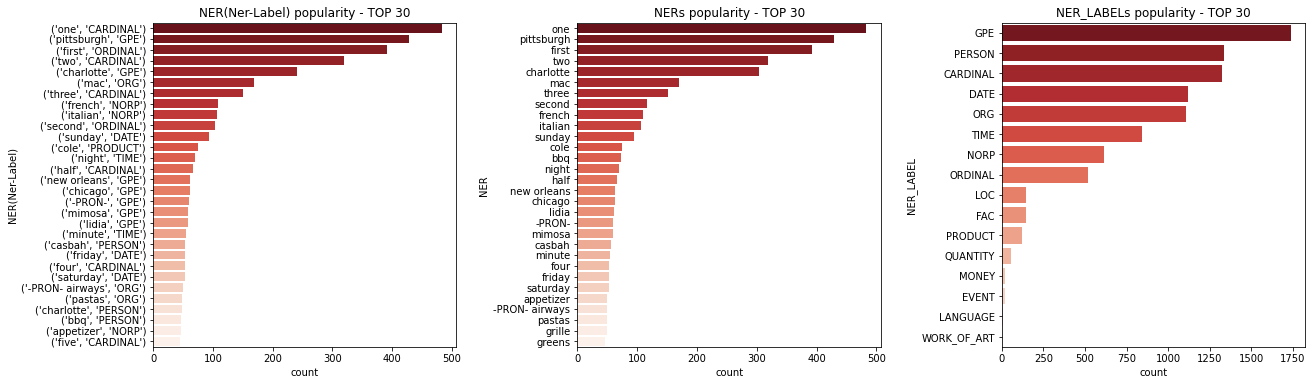

In [153]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,5))

axes[0].set_title("NER(Ner-Label) popularity - TOP 30")
sns.countplot(y=df1.explode('NER(Ner-Label)')['NER(Ner-Label)'], order=df1.explode('NER(Ner-Label)')['NER(Ner-Label)'].value_counts().index[:30], ax=axes[0],palette='Reds_r')
axes[1].set_title("NERs popularity - TOP 30")
sns.countplot(y=df1.explode('NER').NER, order=df1.explode("NER").NER.value_counts().index[:30], ax=axes[1],palette='Reds_r')
axes[2].set_title("NER_LABELs popularity - TOP 30")
sns.countplot(y=df1.explode('NER_LABEL').NER_LABEL, order=df1.explode("NER_LABEL").NER_LABEL.value_counts().index[:30], ax=axes[2],palette='Reds_r')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

De los gráficos se observa que las reviews tratan (en mayor medida) de ubicaciones geográficas, personas, personas de distintas nacionalidades, tiempos, fechas  

Haremos dos wordclouds, una de entidades y otra de sus respectivas labels, para tener una idea preliminar de cuáles son las entidades (y etiquetas) que son nombradas con mayor frecuencia en las reviews

In [154]:
from wordcloud import WordCloud

In [155]:
word_cloud = WordCloud(collocations = False,
                       background_color = 'white',
                       width = 800, height = 800,
                       stopwords = nlp.Defaults.stop_words, 
                       ).generate(str(df1["NER"].values))

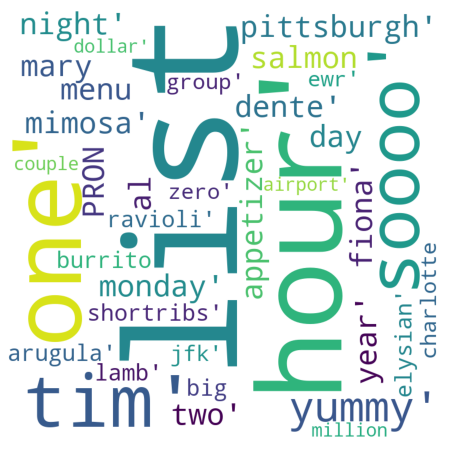

In [156]:
plt.figure(figsize=(8,8))
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

In [157]:
word_cloud_label = WordCloud(collocations = False,
                       background_color = 'white',
                       width = 800, height = 800,
                       stopwords = nlp.Defaults.stop_words, 
                       ).generate(str(df1["NER_LABEL"].values))

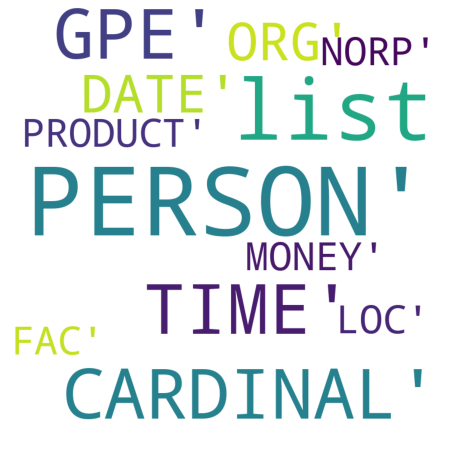

In [158]:
plt.figure(figsize=(8,8))
plt.imshow(word_cloud_label)
plt.axis("off")
plt.show()

Definimos la función "get_nouns" con el fin de obtener los distintos sustantivos que figuran en las reviews. Una vez hecho ésto, incorporaremos la columna "Nouns" a nuestro dataframe para posteriormente lematizala

In [159]:
def get_nouns(text):
  nouns=[]
  for token in nlp(text):
    if token.pos_ == 'NOUN':
      nouns.append(token.text)
  return nouns

In [160]:
%%time
df1['NOUNS'] = df1.TEXT.apply(get_nouns)
df1["NOUNS"] = df1.NOUNS.apply(lambda lemmatizado: [lemma(k) for k in lemmatizado])

CPU times: user 8min 49s, sys: 2.12 s, total: 8min 51s
Wall time: 8min 49s


Obtenemos las keywords. Para ello, primero importamos la librería keyBERT, extraemos las keywords y las incorporamos al dataframe como una nueva columna. A continuación las lematizamos

In [161]:
from keybert import KeyBERT

kw_model = KeyBERT()

In [162]:
%%time
df1["KEYWORDS"] = df1.TEXT.apply(lambda x: kw_model.extract_keywords(x, top_n=3, keyphrase_ngram_range=(1,1)))
df1["KEYWORDS"] = df1.KEYWORDS.apply(lambda keywords: [k[0] for k in keywords])
df1["KEYWORDS"] = df1.KEYWORDS.apply(lambda lemmatizado: [lemma(k) for k in lemmatizado])
df1.head()

CPU times: user 20min 41s, sys: 1min 41s, total: 22min 22s
Wall time: 11min 53s


Graficamos y comparamos

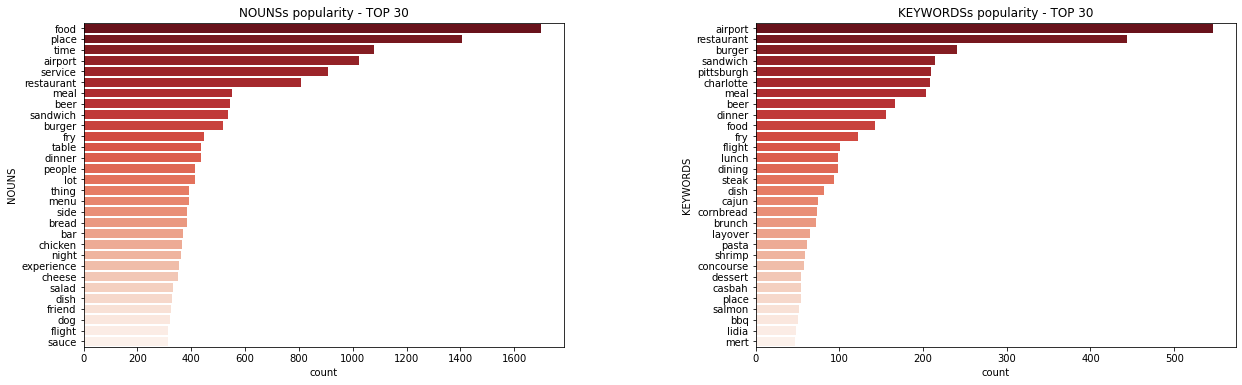

In [163]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))

axes[0].set_title("NOUNSs popularity - TOP 30")
sns.countplot(y=df1.explode('NOUNS').NOUNS, order=df1.explode("NOUNS").NOUNS.value_counts().index[:30], ax=axes[0],palette='Reds_r')
axes[1].set_title("KEYWORDSs popularity - TOP 30")
sns.countplot(y=df1.explode('KEYWORDS').KEYWORDS, order=df1.explode("KEYWORDS").KEYWORDS.value_counts().index[:30], ax=axes[1],palette='Reds_r')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

Si bien no son idénticos (no deberían porqué serlo) son muy semejantes. Las principales keywords figuran dentro del TOP -10 de Nouns, siendo aeropuerto, restaurante, comidas las que más destacan

Obtención de tópicos

In [164]:
from bertopic import BERTopic

In [165]:
topic_model = BERTopic(calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(df1["TEXT"].values)

Batches:   0%|          | 0/76 [00:00<?, ?it/s]

2022-02-01 11:57:24,508 - BERTopic - Transformed documents to Embeddings
2022-02-01 11:57:39,384 - BERTopic - Reduced dimensionality with UMAP
2022-02-01 11:57:39,557 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [166]:
topics_data = topic_model.get_topic_info()
topics_data

,Topic,Count,Name
0,0,1317,0_the_and_was_to
1,1,537,1_to_airport_the_and
2,2,250,2_the_sandwich_and_it
3,3,169,3_beer_the_and_dog
4,-1,55,-1_the_burger_and_it
5,4,50,4_burger_tessaro_the_and
6,5,36,5_burger_the_burgers_it
7,6,15,6_burger_the_pittsburgh_burgers


Se detectaron 7 tópicos ('-1' representa outliers)

In [167]:
df1["Topic"] = topics
df1 = df1.merge(topics_data, on="Topic", how="left")

In [168]:
df1 = df1.rename(columns={"Topic":"TOPIC","Count": "TOPIC_POPULARITY"})
df1.head()

,TEXT,BUSINESS_ID,STARS,DATE,SENTIMENT,NER(Ner-Label),NER,NER_LABEL,NOUNS,KEYWORDS,TOPIC,TOPIC_POPULARITY,Name
0,great stuff here the cheese plates are great a...,83,4,2007-04-25,POS,"[(tim, PERSON)]",[tim],[PERSON],"[stuff, cheese, plate, staff, menu, variety, w...","[plate, cheese, waiter]",0,1317,0_the_and_was_to
1,this place used to have a great bar tapas menu...,83,4,2007-07-16,POS,"[(hour, TIME), (soooo, GPE), (yummy, LOC), (pi...","[hour, soooo, yummy, pittsburgh, mary mimosa, ...","[TIME, GPE, LOC, GPE, PERSON, PERSON, GPE]","[place, bar, tapa, selection, hour, wine, spec...","[wine, entree, seafood]",0,1317,0_the_and_was_to
2,well it official shadyside is becoming my new ...,83,4,2008-06-24,POS,"[(last night, TIME), (monday, DATE), (almost e...","[last night, monday, almost every day of the y...","[TIME, DATE, DATE, CARDINAL, TIME, CARDINAL, P...","[shadyside, area, restaurant, group, ingredien...","[restaurant, dining, wine]",0,1317,0_the_and_was_to
3,as the reviews of casbah appear to be particul...,83,5,2008-06-24,POS,"[(casbah, PERSON), (ish, NORP)]","[casbah, ish]","[PERSON, NORP]","[review, place, food, lover, restaurant]","[casbah, restaurant, review]",0,1317,0_the_and_was_to
4,the food here is pretty good comparable to any...,83,4,2008-07-16,POS,"[(pittsburgh, GPE)]",[pittsburgh],[GPE],"[food, date, restaurant, star, restaurant]","[restaurant, restaurant, pittsburgh]",2,250,2_the_sandwich_and_it


Visualizamos la distancia intertópico

In [169]:
topic_model.visualize_topics()

In [170]:
df1 = df1.drop('Name', axis=1)

Seguidamente, buscaremos las keywords más frecuentes por tópico

In [171]:
topic_keywords = df1.explode("KEYWORDS").groupby(["TOPIC"]).agg({"KEYWORDS": pd.Series.mode})
topic_keywords = topic_keywords.rename(columns={"KEYWORDS": "TOPIC_MOST_FREQ_KEYWORD"})
df1 = df1.merge(topic_keywords, how='left', on="TOPIC")
df1.sample(3)

,TEXT,BUSINESS_ID,STARS,DATE,SENTIMENT,NER(Ner-Label),NER,NER_LABEL,NOUNS,KEYWORDS,TOPIC,TOPIC_POPULARITY,TOPIC_MOST_FREQ_KEYWORD
1365,it a local treasure that may be overlooked in ...,511,4,2012-01-28,POS,"[(charlotte, GPE), (the mimosa grille, FAC), (...","[charlotte, the mimosa grille, restraunt week,...","[GPE, FAC, DATE, ORDINAL]","[treasure, city, mistake, rise, city, purveyor...","[hostess, customer, culinary]",0,1317,restaurant
1828,wonderful food and wonderful music every night,979,5,2014-12-03,POS,"[(every night, TIME)]",[every night],[TIME],"[food, music, night]","[music, food, night]",0,1317,restaurant
457,i love this place their sammies are awesome i ...,514,4,2011-12-22,POS,"[(french, NORP)]",[french],[NORP],"[place, sammie, fan, picture, sandwhich, coles...","[coleslaw, fry, eat]",2,250,sandwich


Más Análisis

Keywords por negocio

In [172]:
df1.explode('KEYWORDS').groupby(['BUSINESS_ID']).agg({'KEYWORDS':'count'}).sort_values(by= 'KEYWORDS',ascending=False).head(10)

,KEYWORDS
BUSINESS_ID,
106,1626
1052,1026
514,762
979,651
83,576
511,564
718,564
85,534
1235,495


Tópicos por negocio

In [173]:
df1.groupby(['BUSINESS_ID']).agg({'TOPIC':'count'}).sort_values(by= 'TOPIC',ascending=False).head(10)

,TOPIC
BUSINESS_ID,
106,542
1052,342
514,254
979,217
83,192
511,188
718,188
85,178
1235,165


Cantidad de tópicos vinculados a un sentimiento

In [174]:
df1.groupby('SENTIMENT').agg({"TOPIC": "count"})

,TOPIC
SENTIMENT,
NEG,84
POS,2345


Lo discriminamos por tópico para mayor información

In [175]:
df1.groupby(['SENTIMENT','TOPIC']).agg({"TEXT": "count"})

TEXT
SENTIMENT TOPIC      
NEG       -1        2
           0       26
           1       37
           2       17
           4        1
           5        1
POS       -1       53
           0     1291
           1      500
           2      233
           3      169
           4       49
           5       35
           6       15

Graficamos. Topicos asociados a sentimientos

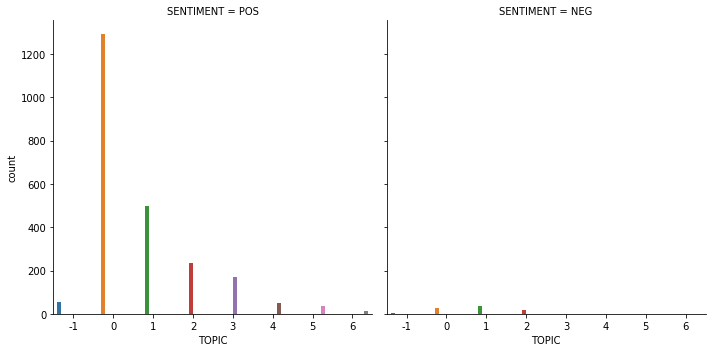

In [176]:
sns.catplot(data = df1, col = 'SENTIMENT',hue='TOPIC',x = 'TOPIC', kind = 'count')
plt.show()

Cantidad de TOPIC_MOST_FREQ_KEYWORD vinculado a un sentimiento

In [177]:
df1.groupby('SENTIMENT').agg({"TOPIC_MOST_FREQ_KEYWORD": "count"})

,TOPIC_MOST_FREQ_KEYWORD
SENTIMENT,
NEG,84
POS,2345


¿Cuáles son esas keywords?

In [178]:
df1.groupby(['SENTIMENT','TOPIC_MOST_FREQ_KEYWORD']).agg({"TOPIC_MOST_FREQ_KEYWORD": "count"})

TOPIC_MOST_FREQ_KEYWORD
SENTIMENT TOPIC_MOST_FREQ_KEYWORD                         
NEG       airport                                       37
          burger                                         4
          restaurant                                    26
          sandwich                                      17
POS       airport                                      500
          beer                                         169
          burger                                       152
          restaurant                                  1291
          sandwich                                     233

Graficamos. Topic Most Frecuent Keywords
vinculadas a un sentimiento. Seguidamente, discriminadas por tópico

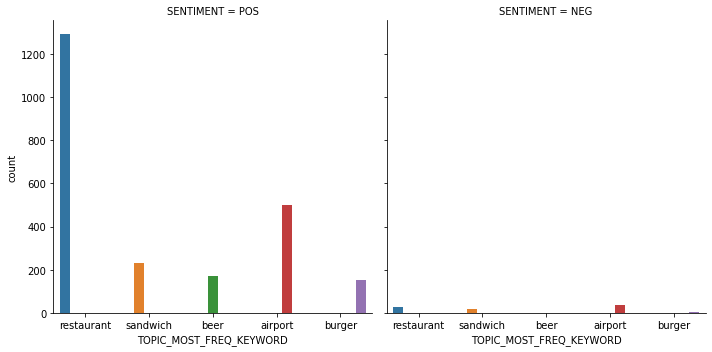

In [179]:
sns.catplot(data = df1, col = 'SENTIMENT',hue='TOPIC_MOST_FREQ_KEYWORD',x = 'TOPIC_MOST_FREQ_KEYWORD', kind = 'count')
plt.show()

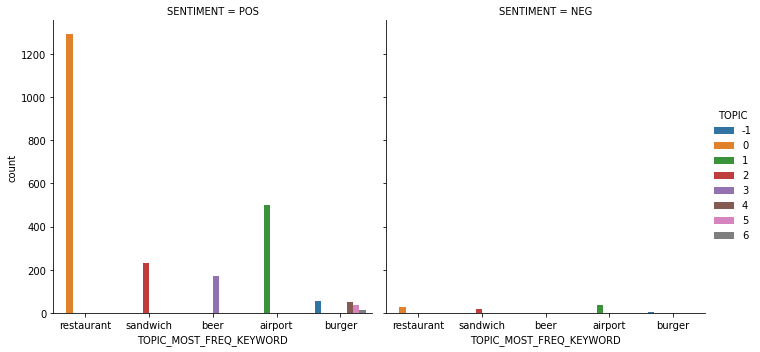

In [180]:
sns.catplot(data = df1, col = 'SENTIMENT',hue='TOPIC',x = 'TOPIC_MOST_FREQ_KEYWORD', kind = 'count')
plt.show()

Entidades por reviews (idem a entidades por tópico)

In [181]:
df3 =df1.explode('NER').groupby('NER', as_index=False).agg({"TOPIC": "count"}).sort_values(by='TOPIC', ascending= False).head(10) 
df3

,NER,TOPIC
1415,one,483
1531,pittsburgh,429
786,first,392
2145,two,319
499,charlotte,303
1183,mac,170
2091,three,152
1700,second,117
819,french,109
991,italian,107


Graficamos. Countplot de entidades     TOP-10 discriminadas por tópico

In [182]:
df4 = df1.explode('NER')[df1.explode('NER').NER.isin(df3.NER)]


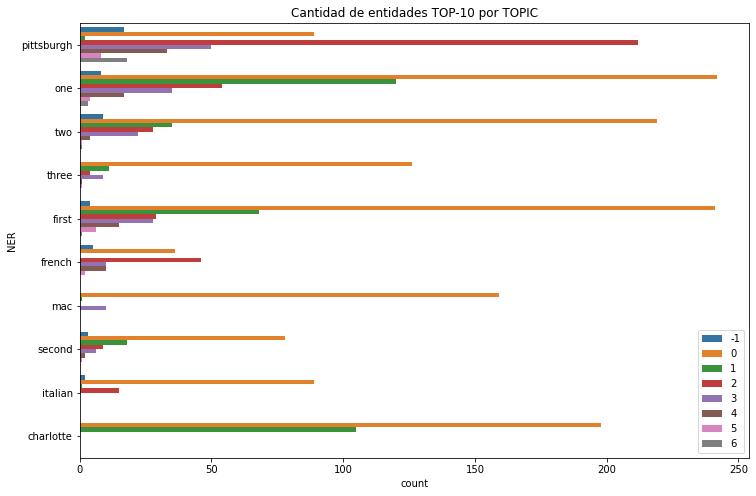

In [183]:
fig = plt.figure(figsize=(12,8))
ax = plt.axes()
ax = sns.countplot(y='NER', data= df4,hue='TOPIC')
plt.title("Cantidad de entidades TOP-10 por TOPIC")
plt.legend(loc= 'lower right')
plt.show()

In [184]:
df1.explode('NER_LABEL').groupby('NER_LABEL').agg({"TEXT": "count"}).sort_values(by='TEXT', ascending= False).head(10)

,TEXT
NER_LABEL,
GPE,1737
PERSON,1339
CARDINAL,1323
DATE,1119
ORG,1109
TIME,841
NORP,612
ORDINAL,519
LOC,144


Graficamos. Countplot  de LABELs de entidades
discriminadas por tópico

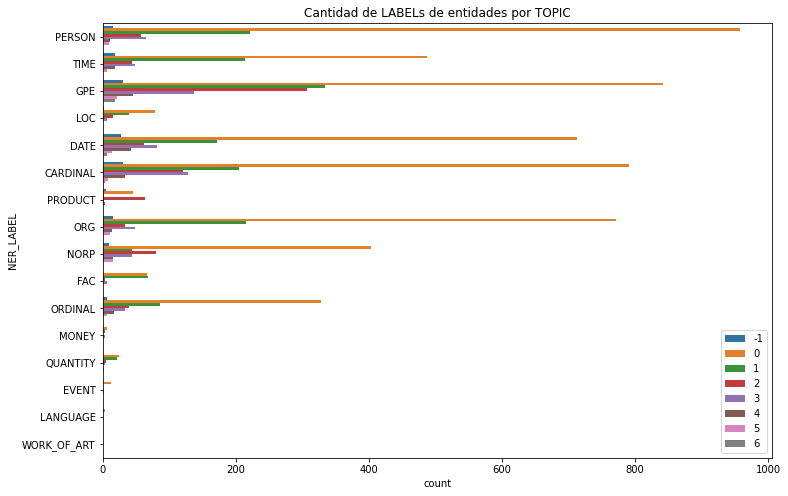

In [185]:
fig = plt.figure(figsize=(12,8))
ax = plt.axes()
ax = sns.countplot(y='NER_LABEL', data= df1.explode('NER_LABEL'),hue='TOPIC')
plt.title("Cantidad de LABELs de entidades por TOPIC")
plt.legend(loc='lower right')
plt.show()

Negocios con más comentarios positivos y negocios con más comentarios negativos

In [186]:
business_sentiments = df1.groupby(["BUSINESS_ID", "SENTIMENT","DATE"], as_index= False).agg({"TEXT": "count"})
business_sentiments.head()

,BUSINESS_ID,SENTIMENT,DATE,TEXT
0,83,NEG,2014-12-23,1
1,83,NEG,2015-01-08,1
2,83,POS,2007-04-25,1
3,83,POS,2007-07-16,1
4,83,POS,2008-06-24,2


In [187]:
business_sentiments['%TEXT'] = business_sentiments.TEXT.apply(lambda x: round(x/business_sentiments.TEXT.sum()*100,2))
business_sentiments.head()

,BUSINESS_ID,SENTIMENT,DATE,TEXT,%TEXT
0,83,NEG,2014-12-23,1,0.04
1,83,NEG,2015-01-08,1,0.04
2,83,POS,2007-04-25,1,0.04
3,83,POS,2007-07-16,1,0.04
4,83,POS,2008-06-24,2,0.08


In [188]:
business_sentiments[business_sentiments.SENTIMENT == 'POS'].sort_values(by="TEXT", ascending=False).head(10)

,BUSINESS_ID,SENTIMENT,DATE,TEXT,%TEXT
1647,979,POS,2011-11-21,3,0.12
522,106,POS,2011-12-16,3,0.12
556,106,POS,2012-05-29,3,0.12
696,106,POS,2014-04-02,3,0.12
961,270,POS,2014-10-05,3,0.12
1273,514,POS,2011-06-17,3,0.12
455,106,POS,2010-11-17,3,0.12
2166,1235,POS,2009-10-01,3,0.12
2001,1052,POS,2014-01-20,3,0.12
1269,514,POS,2011-05-18,3,0.12


In [189]:
business_sentiments[business_sentiments.SENTIMENT == 'NEG'].sort_values(by="TEXT", ascending=False).head(10)

,BUSINESS_ID,SENTIMENT,DATE,TEXT,%TEXT
365,106,NEG,2012-12-14,2,0.08
0,83,NEG,2014-12-23,1,0.04
1203,514,NEG,2013-09-23,1,0.04
1210,514,NEG,2015-04-11,1,0.04
1209,514,NEG,2015-03-19,1,0.04
1208,514,NEG,2014-08-29,1,0.04
1207,514,NEG,2014-07-28,1,0.04
1206,514,NEG,2014-04-24,1,0.04
1205,514,NEG,2014-02-15,1,0.04
1204,514,NEG,2013-11-18,1,0.04


Graficamos. Cantidad de reviews por negocio         TOP-10 asociado a un sentimiento

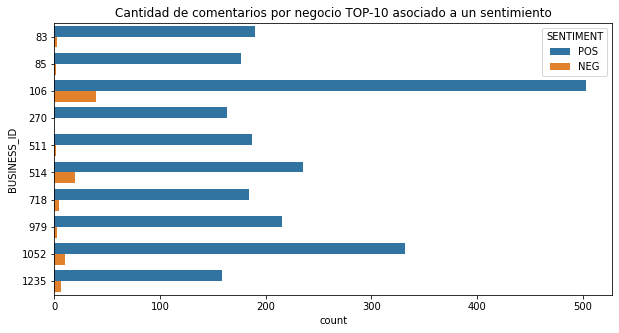

In [190]:
fig = plt.figure(figsize=(10,5))
ax = sns.countplot(y='BUSINESS_ID',data= df1[df1.BUSINESS_ID.isin(business_sentiments.BUSINESS_ID)], hue ='SENTIMENT')
plt.title("Cantidad de comentarios por negocio TOP-10 asociado a un sentimiento")
plt.show()

Obtenemos para cada negocio el porcentaje de reviews negativas y el porcentaje de reviews positivas

In [ ]:
business_sentiments_2 = df1.groupby(["BUSINESS_ID", "SENTIMENT"]).agg({"TEXT": "count"})
business_sentiments_2 = business_sentiments_2.unstack()

In [192]:
business_sentiments_2['%NEG'] = business_sentiments_2[('TEXT', 'NEG')].fillna(0) / (business_sentiments_2[('TEXT', 'NEG')].fillna(0) + business_sentiments_2[('TEXT', 'POS')].fillna(0))
business_sentiments_2['%POS'] = business_sentiments_2[('TEXT', 'POS')].fillna(0) / (business_sentiments_2[('TEXT', 'NEG')].fillna(0) + business_sentiments_2[('TEXT', 'POS')].fillna(0))
business_sentiments_2

TEXT             %NEG      %POS
SENTIMENT     NEG    POS                    
BUSINESS_ID                                 
83            2.0  190.0  0.010417  0.989583
85            1.0  177.0  0.005618  0.994382
106          39.0  503.0  0.071956  0.928044
270           NaN  163.0  0.000000  1.000000
511           1.0  187.0  0.005319  0.994681
514          19.0  235.0  0.074803  0.925197
718           4.0  184.0  0.021277  0.978723
979           2.0  215.0  0.009217  0.990783
1052         10.0  332.0  0.029240  0.970760
1235          6.0  159.0  0.036364  0.963636

Graficamos. Barras apiladas del porcentaje de reviews negativas y positivas por cada uno de los negocios

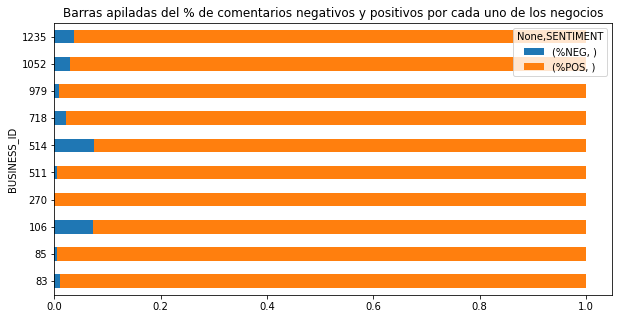

In [193]:
business_sentiments_2[[('%NEG',''),('%POS','')]].plot( kind = 'barh', stacked = True, figsize=(10,5), title = 'Barras apiladas del % de comentarios negativos y positivos por cada uno de los negocios')

A continuación, buscaremos encontrar el porcentaje acumulado de reviews de los distintos negocios con el fin de poder graficar un diagrama de Pareto

In [194]:
df5 = df1[df1.BUSINESS_ID.isin(business_sentiments.BUSINESS_ID)]

In [195]:
a = df5['BUSINESS_ID'].value_counts()
a

106     542
1052    342
514     254
979     217
83      192
511     188
718     188
85      178
1235    165
270     163
Name: BUSINESS_ID, dtype: int64

In [196]:
import numpy as np

In [197]:
acumulado = round(np.cumsum(a)/sum(a)*100,2)
acumulado

106      22.31
1052     36.39
514      46.85
979      55.78
83       63.69
511      71.43
718      79.17
85       86.50
1235     93.29
270     100.00
Name: BUSINESS_ID, dtype: float64

In [198]:
df_acum = pd.DataFrame(acumulado)
df_acum.reset_index(inplace=True)
df_acum = df_acum.rename(columns={'index':'BUSINESS_ID','BUSINESS_ID':'% Acumulado'})
df_acum.BUSINESS_ID = df_acum.BUSINESS_ID.astype(str)
df_acum = df_acum.sort_values(by='% Acumulado',ascending=False)
df_acum

,BUSINESS_ID,% Acumulado
9,270,100.00
8,1235,93.29
7,85,86.50
6,718,79.17
5,511,71.43
4,83,63.69
3,979,55.78
2,514,46.85
1,1052,36.39
0,106,22.31


Graficamos. Pareto

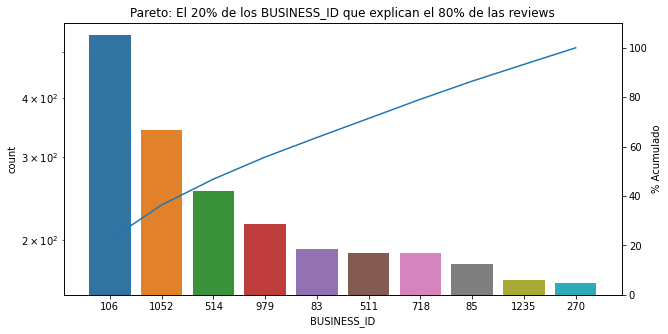

In [199]:
fig = plt.figure(figsize=(10,5))
ax= plt.axes()
ax = sns.countplot(x='BUSINESS_ID', data=df5 ,order= df5['BUSINESS_ID'].value_counts().index) 
ax.set_yscale('log')
ax2 = ax.twinx()
ax2 = sns.lineplot(x=df_acum.index, y = '% Acumulado',sort= False, data= df_acum)
ax2.set_ylim([0, 110])
plt.xticks(rotation=90)
plt.title("Pareto: El 20% de los BUSINESS_ID que explican el 80% de las reviews")
plt.show()

Como podemos observar en el gráfico, hasta el “BUSINESS_ID = 718”, tendríamos el 20% de los negocios que explican el 80% de las reviews

Estrellas vinculadas a un sentimiento. Claro está que entre más estrellas tenga un negocio, implica que éste gustó más, por lo que debería estar asociado a un sentimiento positivo (lo mismo sucede a la inversa)

In [200]:
df1.groupby('SENTIMENT').agg({'STARS':'sum'}) 

,STARS
SENTIMENT,
NEG,156
POS,9461


Ahora lo discriminamos por tópico para mayor información

In [201]:
df1.groupby(['SENTIMENT','TOPIC']).agg({'STARS':'sum'})

STARS
SENTIMENT TOPIC       
NEG       -1         3
           0        53
           1        67
           2        31
           4         1
           5         1
POS       -1       203
           0      5324
           1      1888
           2       892
           3       738
           4       212
           5       138
           6        66

Graficamos. Estrellas asociadas a un sentimiento. Seguidamente, discriminadas por tópico

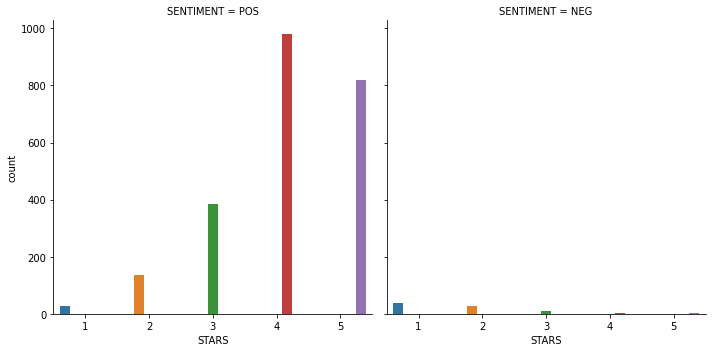

In [202]:
sns.catplot(data = df1, col = 'SENTIMENT',hue='STARS',x = 'STARS', kind = 'count')
plt.show()

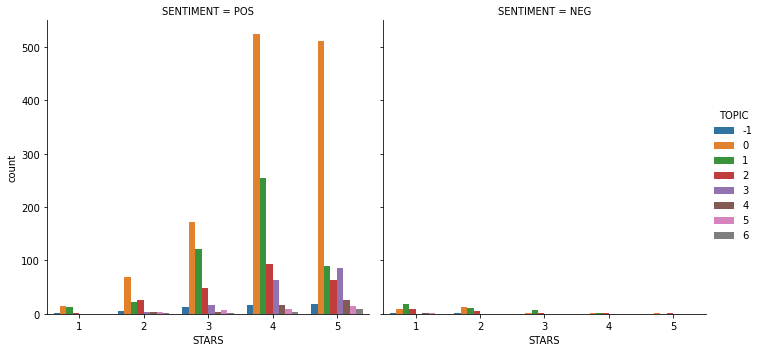

In [203]:
sns.catplot(data = df1, col = 'SENTIMENT',hue='TOPIC',x = 'STARS', kind = 'count')
plt.show()

Graficamos. Evolución en el tiempo del porcentaje de reviews 
asociadas a los distintos negocios. 
Seguidamente, del porcentaje de reviews   > 0.07 % del total


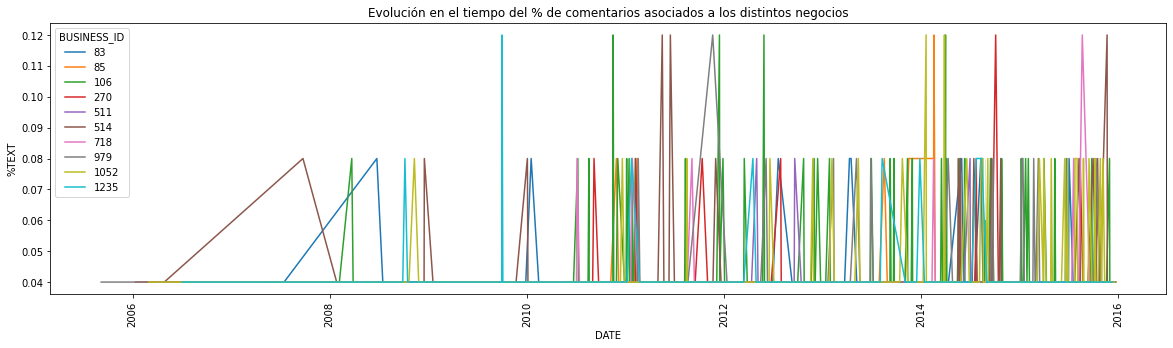

In [204]:
fig = plt.figure(figsize=(20,5))
ax = plt.axes()
ax = sns.lineplot(x='DATE', y='%TEXT', hue= 'BUSINESS_ID', data=business_sentiments, palette = "tab10" )
plt.xticks(rotation=90)
plt.title("Evolución en el tiempo del % de comentarios asociados a los distintos negocios")
plt.show()

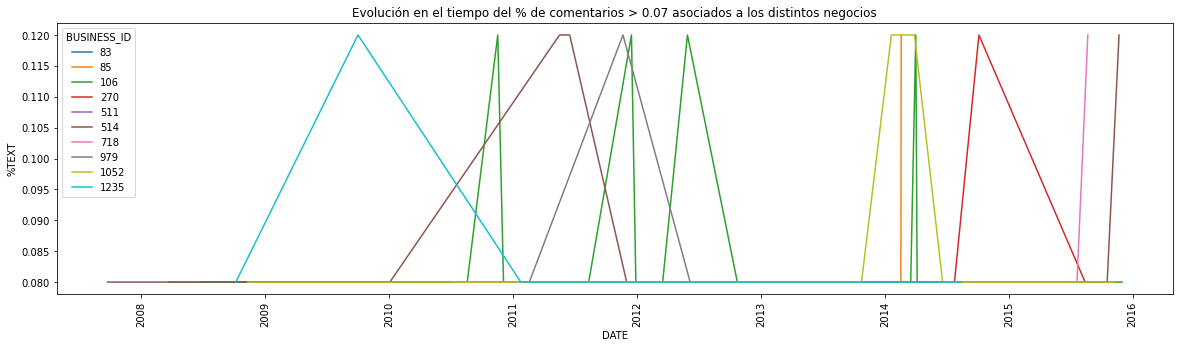

In [205]:
fig = plt.figure(figsize=(20,5))
ax = plt.axes()
ax = sns.lineplot(x='DATE', y='%TEXT', hue= 'BUSINESS_ID', data=business_sentiments[business_sentiments['%TEXT'] > 0.07], palette = "tab10" )
plt.xticks(rotation=90)
plt.title("Evolución en el tiempo del % de comentarios > 0.07 asociados a los distintos negocios")
plt.show()

Graficamos. Evolución en el tiempo de los sentimientos asociados a las reviews  de los distintos negocios

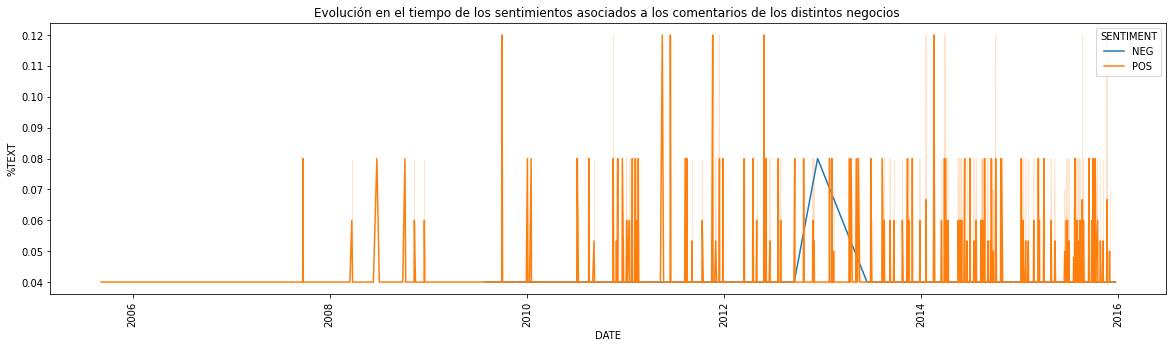

In [206]:
fig = plt.figure(figsize=(20,5))
ax = plt.axes()
ax = sns.lineplot(x='DATE', y='%TEXT', hue= 'SENTIMENT', data=business_sentiments )
plt.xticks(rotation=90)
plt.title("Evolución en el tiempo de los sentimientos asociados a los comentarios de los distintos negocios ")
plt.show()

Se puede observar que las reviews asociadas a  sentimientos negativos rondan alrededor del año 2013 y no son la mayoría (< 0.08% del total)

In [207]:
business_sentiments['STARS']= df1['STARS'].copy()

In [208]:
business_sentiments.head()

,BUSINESS_ID,SENTIMENT,DATE,TEXT,%TEXT,STARS
0,83,NEG,2014-12-23,1,0.04,4
1,83,NEG,2015-01-08,1,0.04,4
2,83,POS,2007-04-25,1,0.04,4
3,83,POS,2007-07-16,1,0.04,5
4,83,POS,2008-06-24,2,0.08,4


Graficamos. Evolución en el tiempo de las estrellas asociadas a las reviews de los distintos negocios. A continuación, de las estrellas asociadas a las reviews  > 0.07% del total






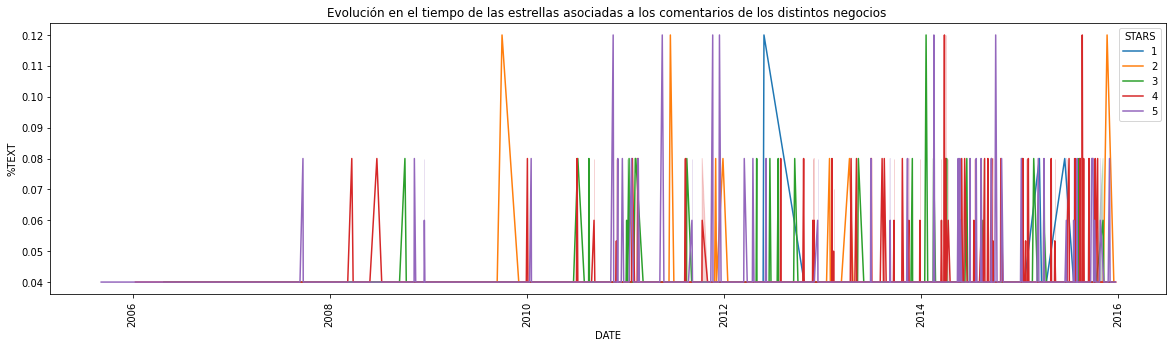

In [209]:
fig = plt.figure(figsize=(20,5))
ax = plt.axes()
ax = sns.lineplot(x='DATE', y='%TEXT', hue= 'STARS', data= business_sentiments, palette= "tab10")
plt.xticks(rotation=90)
plt.title("Evolución en el tiempo de las estrellas asociadas a los comentarios de los distintos negocios ")
plt.show()

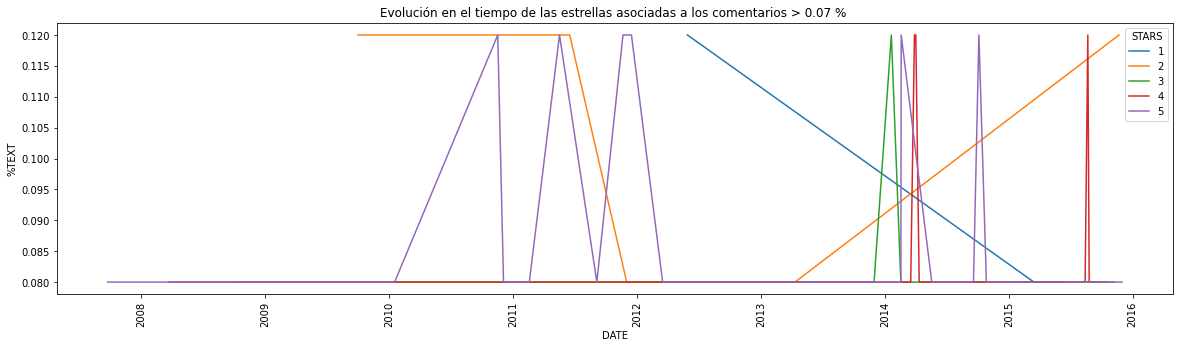

In [210]:
fig = plt.figure(figsize=(20,5))
ax = plt.axes()
ax = sns.lineplot(x='DATE', y='%TEXT', hue= 'STARS', data= business_sentiments[business_sentiments['%TEXT'] > 0.07 ], palette= "tab10")
plt.xticks(rotation=90)
plt.title("Evolución en el tiempo de las estrellas asociadas a los comentarios > 0.07 % ")
plt.show()